In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = "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"
os.environ['AZURE_OPENAI_API_KEY'] = os.getenv("AZURE_OPENAI_API_KEY")

In [4]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    model="gpt_4o",
    azure_deployment="odda_gpt",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    openai_api_type=os.getenv("AZURE_OPENAI_API_TYPE"),
    api_version=os.getenv("AZURE_OPENAI_VERSION"),
    temperature=0
)



In [5]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

In [6]:
def add_one(input: list[HumanMessage]):
    input[0].content = input[0].content + "a"
    return input

def add_two(input: list[HumanMessage]):
    input[0].content = input[0].content + "b"
    return input

graph = MessageGraph()

graph.add_node("branch_a", add_one)
graph.add_edge("branch_a","branch_b")
graph.add_edge("branch_a","branch_c")

graph.add_node("branch_b", add_one)
graph.add_node("branch_c", add_two)

graph.add_edge("branch_c","final_node")
graph.add_edge("branch_b","final_node")

graph.add_node("final_node", add_one)
graph.add_edge("final_node",END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

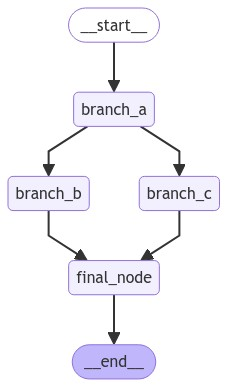

In [7]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [8]:
runnable.invoke("a")

[HumanMessage(content='aaaba', id='d207a8ce-d741-4b72-bce3-de010fa26457')]

In [9]:
from langgraph.graph import MessageGraph, END
from langchain_core.messages import HumanMessage

def entry(input: list[HumanMessage]):
    return input

def work_with_b(input: list[HumanMessage]):
    print("Using Branch B")
    return input

def work_with_c(input: list[HumanMessage]):
    print("Using Branch C")
    return input

def router(input: list[HumanMessage]):
    if "use_b" in input[0].content:
        return "branch_b"
    else:
        return "branch_c"
    
graph = MessageGraph()

graph.add_node("branch_a", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)

graph.add_conditional_edges(
    "branch_a",
    router,
    {"branch_b":"branch_b","branch_c":"branch_c"}
)

graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

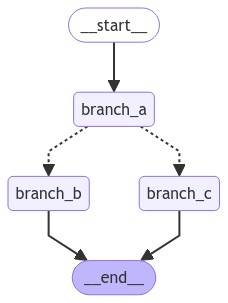

In [16]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [10]:
runnable.invoke("I think for this one you should try branch c")

Using Branch C


[HumanMessage(content='I think for this one you should try branch c', id='ae7798ee-05ff-41af-84e4-937b32dc8e29')]

In [11]:
runnable.invoke("I think for this one you should try branch c, how are you?")

Using Branch C


[HumanMessage(content='I think for this one you should try branch c, how are you?', id='83162431-c140-454d-92b0-6328010c599c')]

In [12]:
runnable.invoke("I think for this one you should try use_b")

Using Branch B


[HumanMessage(content='I think for this one you should try use_b', id='d6f02c21-eaa4-456e-9fc2-d89c4c5e7f75')]

In [13]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

llm = AzureChatOpenAI(
    model="gpt_4o",
    azure_deployment="odda_gpt",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    openai_api_type=os.getenv("AZURE_OPENAI_API_TYPE"),
    api_version=os.getenv("AZURE_OPENAI_VERSION"),
    temperature=0
)

def entry(input: list[HumanMessage]):
    return input

def action(input: list[HumanMessage]):
    print("Action taken:", [msg.content for msg in input])
    if len(input) > 5:
        input.append(HumanMessage(content="end"))
    else:
        input.append(HumanMessage(content="continue"))
    return input

def should_continue(input: list):
    last_message = input[-1]
    if "end" in last_message.content:
        return "__end__"
    return "action"


graph = MessageGraph()

graph.add_node("agent", entry)
graph.add_node("action", action)

graph.add_conditional_edges(
    "agent",
    should_continue,
    {"action":"action","__end__":END}
)

graph.set_entry_point("agent")
graph.add_edge("action","agent")

runnable = graph.compile()

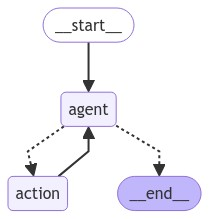

In [14]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [15]:
runnable.invoke("one")

Action taken: ['one']
Action taken: ['one', 'continue']
Action taken: ['one', 'continue', 'continue']
Action taken: ['one', 'continue', 'continue', 'continue']
Action taken: ['one', 'continue', 'continue', 'continue', 'continue']
Action taken: ['one', 'continue', 'continue', 'continue', 'continue', 'continue']


[HumanMessage(content='one', id='59682c9f-1d84-4089-b978-dedf66e6f9f1'),
 HumanMessage(content='continue', id='472df9f7-d463-4624-a2b6-7454a839f024'),
 HumanMessage(content='continue', id='7a0140cd-1d25-4787-8668-eee4989600f7'),
 HumanMessage(content='continue', id='d301104b-9e05-4ac6-b2f7-35963fc2c5d6'),
 HumanMessage(content='continue', id='27f9db25-a83e-4ecf-9696-af33f19e081c'),
 HumanMessage(content='continue', id='539af71b-4351-4beb-bd18-da2dd1c35229'),
 HumanMessage(content='end', id='7f6589e7-6914-4f39-a6f9-a7f9a7cf8c96')]

In [16]:
## We will also now create a custom state
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    api_call_count: int = 0

In [17]:
### now we need to create the tool from Langchain 

from langchain_core.tools import tool
# from langchain_community.tools.tavily_search import TavilySearchResults

# os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

# tools = [TavilySearchResults(max_results=1)]

import random


@tool
def fake_weather_api(city: str) -> str:
    """Check the weather in a specified city. The API is available randomly, approximately every third call."""

    if random.randint(1, 2) == 1:  # Approximately one-third chance
        return "Sunny, 22°C"
    else:
        return "Rainy, 4°C"

In [18]:
print(fake_weather_api("New York"))
print(fake_weather_api("London"))
print(fake_weather_api("Berlin"))

Rainy, 4°C
Sunny, 22°C
Rainy, 4°C


/Users/talwapul/Documents/LangChainRP/langgraph/venv/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [20]:
llm_with_tools = llm.bind_tools([fake_weather_api])

In [21]:
from langchain_core.messages import HumanMessage, ToolMessage

tool_mapping = {"fake_weather_api": fake_weather_api}

messages = [HumanMessage("How will the weather be in Munich today? I would like to eat outdoors if possible.")]

llm_output = llm_with_tools.invoke(messages)

messages.append(llm_output)

print(messages)

[HumanMessage(content='How will the weather be in Munich today? I would like to eat outdoors if possible.'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VlHh5ZPjvfzWaz79DS6Htg0X', 'function': {'arguments': '{"city":"Munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 75, 'total_tokens': 91}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_80a1bad4c7', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-5994edb9-ffd9-42fe-9a64-2e3624a6d003-0', tool_calls=[{'name': 'fake_weather_api', 'args': {'city': 'Munich'}, 'id': 'call_VlHh5ZPjvfzWaz79DS6Htg0X', 

In [22]:
for tool_call in llm_output.tool_calls:
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

llm_with_tools.invoke(messages)

AIMessage(content='The weather in Munich today is sunny with a temperature of 22°C. It sounds like a perfect day to eat outdoors! Enjoy your meal!', response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 105, 'total_tokens': 135}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_80a1bad4c7', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run-70329839-cbab-4c84-bd1c-785e9032a802-0', usage_metadata={'input_tokens': 105, 'output_tokens': 30, 'tot

In [23]:
def should_continue(state: AgentState):
    print("STATE:", state)
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"
    
def call_model(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages":[response], "api_call_count":state["api_call_count"]}

def call_tool(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    state["api_call_count"] += 1
    print("Tool output:", tool_output)
    print("API call count after this tool call:", state["api_call_count"])
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages": [tool_message], "api_call_count": state["api_call_count"]}


In [24]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue":"action",
        "end":END,
    }
)

workflow.add_edge("action","agent")

app = workflow.compile()

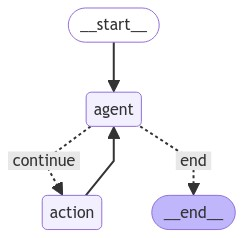

In [25]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [26]:
from langchain_core.messages import SystemMessage

system_message = SystemMessage(
    content="You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again"
)
human_message = HumanMessage(content="How is the weather in munich today?")
messages = [system_message, human_message]

result = app.invoke({"messages": messages, "api_call_count": 0})

STATE: {'messages': [SystemMessage(content='You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again'), HumanMessage(content='How is the weather in munich today?'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NwWuxGDUl6Osbb7l1VzlDOUE', 'function': {'arguments': '{"city":"Munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 94, 'total_tokens': 110}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_80a1bad4c7', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run

In [27]:
print(result["messages"][-1].content)
print(result["api_call_count"])

The weather in Munich today is sunny with a temperature of 22°C. Enjoy your day!
1


 Lets use RAG pipeline for LCEL and LangGraph

In [28]:
from langchain.schema import Document
from langchain_openai import AzureOpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

embedding_function = AzureOpenAIEmbeddings(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    model="text-embedding-3-small",
    azure_deployment="pt-sm-embd"
)

docs = [
    Document(
        page_content="the dog loves to eat pizza", metadata={"source":"animal.txt"}

    ),
    Document(
        page_content="the cat loves to eat lasanga", metadata={"source":"animal.txt"}

    )
]

vectorDB = Chroma.from_documents(docs, embedding_function)

retriever = vectorDB.as_retriever(search_kwargs={"k":2})

def format_docs(docs):
    return "\n\n" .join(doc.page_content for doc in docs)

In [29]:
template = """
Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

retrieval_chain = (
    ### In this retrieval chain the origin line (below) creates a RunnableParallel which passes the original question unchanged to both elements
    {"context":retriever | format_docs, "question":RunnablePassthrough()} 
    | prompt 
    | llm 
    | StrOutputParser()
)

## this is an example of a DAG workflow > direct acyclic graph

In [30]:
retrieval_chain.invoke(input="What food does the cat like?")

'The cat loves to eat lasagna.'

In [31]:
### In LangGraph we dont need the RAG pipeline, only need the prompt, the model and the outputparser
from typing import TypedDict
from langchain_core.messages import BaseMessage

chain_with_prompt = prompt | llm | StrOutputParser()

In [32]:
class AgentState(TypedDict):
    """
    Defining the agent state where it shows the data to be retrieved
    """
    question: str
    raw_docs: list[BaseMessage]
    formatted_docs: list[str]
    generation: str

# """
# This is one of the main differences of LCEL, is that everything is stored in a central place aka the AgentState.

# In LCEL we just pass in data through a pipeline. Here we store it in a central agent state.

# LangGraph also works with nodes and edges, so each function we have will be assigned to a node which is executed. 

# #### LANGGRAPH

# So for each step (NODE) we have to provide a function > which uses the STATE> and does something with it and at the end returns the STATE

# """

In [33]:
def get_docs(state: AgentState):
    print("get_docs:", state)
    question = state["question"]
    docs = retriever.invoke(question)
    state["raw_docs"] = docs
    return state

def format_docs(state: AgentState):
    print("format_docs:", state)
    documents = state["raw_docs"]
    state["formatted_docs"] = "\n\n".join(doc.page_content for doc in documents)
    return state

def generate(state: AgentState):
    print("generate:", state)
    ## we need to extract all the parameters to give it to the LLM
    question = state["question"]
    formatted_docs = state["formatted_docs"]
    result = chain_with_prompt.invoke({"question":question, "context":formatted_docs})
    state["generation"] = result
    return state

In [34]:
### NOW IN LANGGRAPH WE DEFINE THE WORKFLOW 

from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

### EVERY NODE HAS A KEY AND A FUNCTION WHICH IS RUN

workflow.add_node("get_docs",get_docs)
workflow.add_node("format_docs",format_docs)
workflow.add_node("generate", generate)

workflow.add_edge("get_docs","format_docs")
workflow.add_edge("format_docs","generate")
workflow.add_edge("generate",END)

workflow.set_entry_point("get_docs")

app = workflow.compile()



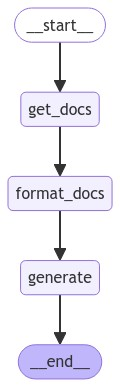

In [35]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [36]:
result = app.invoke({"question":"what food does the cat like?"})

result

get_docs: {'question': 'what food does the cat like?', 'raw_docs': None, 'formatted_docs': None, 'generation': None}
format_docs: {'question': 'what food does the cat like?', 'raw_docs': [Document(metadata={'source': 'animal.txt'}, page_content='the cat loves to eat lasanga'), Document(metadata={'source': 'animal.txt'}, page_content='the dog loves to eat pizza')], 'formatted_docs': None, 'generation': None}
generate: {'question': 'what food does the cat like?', 'raw_docs': [Document(metadata={'source': 'animal.txt'}, page_content='the cat loves to eat lasanga'), Document(metadata={'source': 'animal.txt'}, page_content='the dog loves to eat pizza')], 'formatted_docs': 'the cat loves to eat lasanga\n\nthe dog loves to eat pizza', 'generation': None}


{'question': 'what food does the cat like?',
 'raw_docs': [Document(metadata={'source': 'animal.txt'}, page_content='the cat loves to eat lasanga'),
  Document(metadata={'source': 'animal.txt'}, page_content='the dog loves to eat pizza')],
 'formatted_docs': 'the cat loves to eat lasanga\n\nthe dog loves to eat pizza',
 'generation': 'The cat loves to eat lasagna.'}

In [37]:
result['generation']

'The cat loves to eat lasagna.'

In [38]:
### LangChain team recommends that we use a LCEL if we need a DAG workflow and use LangGraph if we need cycles in a workflow.result
# Therefore for the above pipeline we RAG pipeline which clearly needs a DAG (direct acyclic graph) workflow

"""
Langgraph could be superior if we wanted to include the documents of the RAG pipeline in the output of the RAG pipeline. 
In Langgraph we can just access the state at any point. 
LCEL chains are very hard to debug and hard to unit test as every node has just a single function or runnable and ONLY works with the STATE.
This is everything you want if you want to design larger software.
"""

'\nLanggraph could be superior if we wanted to include the documents of the RAG pipeline in the output of the RAG pipeline. \nIn Langgraph we can just access the state at any point. \nLCEL chains are very hard to debug and hard to unit test as every node has just a single function or runnable and ONLY works with the STATE.\nThis is everything you want if you want to design larger software.\n'

In [39]:
### We will create and agent system where we have multiple autonomous agents when LLM is a key part of each agent

### Team of Agents with a Supervisor

In [49]:
# Imports 
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

## Lets start by implementing the Evaluator agent.
# this agent is responsible for telling the next agent if an article is worthy or relevant to be posted or not
# we are going make this by using a structured output and use a pydantic class here
# THIS IS BECAUSE FOR THIS WE ARE USING ROUTING - using function calling and not semantic routing

class TransferNewsGrader(BaseModel):
    """ Binary score for relevance check on football transfer news"""
    binary_score: str = Field(
        ### this is what we are going to get back from the LLM
        description="The article is about football transfers, 'yes' or 'no'"
    )

structured_llm_grader = llm.with_structured_output(TransferNewsGrader)

system = """ You are a grader assessing whether a news article concerns a football transfer \n
Check if the article explicitly mentions player transfer between clubs, potential transfers or confirmed transfers. \n
Provide a binary score 'yes' or 'no' to indicate whether the news us about football transfer. """

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human", "News Article: \n\n {article}")
    ]
)

evaluator = grade_prompt | structured_llm_grader

In [53]:
result = evaluator.invoke("There is are some rumours that Messi will switch from Real Madrid to FC Barcelona")

In [55]:
result = evaluator.invoke("its my birthday tomorrow")

In [56]:
result.binary_score

'no'

In [58]:
## Now we can continue with the News Chef who is responsible for evaluating if an article is ready to be posted

class ArticlePostabilityGrader(BaseModel):
    """ Binary scores for postability check, word count, sensationalism, and language translation of a news article"""

    can_be_posted: str = Field(
        description="The article is ready to post 'yes' or 'no'"
    )
    meets_word_count: str = Field(
        description="The article is has at least 200 words, 'yes' or 'no'"
    )
    is_sensationalistic: str = Field(
        description="The article is written in a sensationalistic style, 'yes' or 'no'"
    )
    is_language_english: str = Field(
        description="The language of the article is English, 'yes' or 'no'"
    )

llm_postability = llm.with_structured_output(ArticlePostabilityGrader)

postability_system = """You are a grader assessing whether a news article is ready to be posted, if it meets the minimum word count of 200 words, is written in a sensationalistic style, and if it is in a language other than English. \n
    Evaluate the article for grammatical errors, completeness, appropriateness for publication, and EXAGERATED sensationalism. \n
    Also, confirm if the language used in the article is English and it meets the word count requirement. \n
    Provide four binary scores: one to indicate if the article can be posted ('yes' or 'no'), one for adequate word count ('yes' or 'no'), one for sensationalistic writing ('yes' or 'no'), and another if the language is not English ('yes' or 'no')."""
postability_grade_prompt = ChatPromptTemplate.from_messages(
    [("system", postability_system), ("human", "News Article:\n\n {article}")]
)

news_chef = postability_grade_prompt | llm_postability

# result = news_chef.invoke(
#     {
#         "article": "Es wurde gemeldet, dass Messi von Real Madrid zu FC Barcelona wechselt."
#     }
# )


In [59]:
result = news_chef.invoke("Es wurde gemeldet, dass Messi von Real Madrid zu FC Barcelona wechselt.")

In [60]:
result

ArticlePostabilityGrader(can_be_posted='no', meets_word_count='no', is_sensationalistic='yes', is_language_english='no')

In [67]:
llm_translation_agent = llm

translation_system = """ You are a multilingual language expert, who can translate anything to English. Translate the text accurately while maintaining the original tone and style."""
translation_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", translation_system),
        ("human","Article to translate: \n\n {article}")
    ]
)

translator = translation_prompt | llm_translation_agent

result = translator.invoke({"article":"Es wurde gemeldet, dass Messi von Real Madrid zu FC Barcelona wechselt."})

print(result)

content='It has been reported that Messi is transferring from Real Madrid to FC Barcelona.' response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 58, 'total_tokens': 73}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_80a1bad4c7', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}} id='run-cec19ee4-b884-45cf-94e6-3257e09cfb30-0' usage_metadata={'input_tokens': 58, 'output_tokens': 15, 'total_tokens': 73}


In [77]:
llm_expander_agent = llm

expansion_system = """You are a writer tasked with expanding the given article to at least 200 words while maintaining relevance, coherence, and the original tone."""
expansion_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",expansion_system),
        ("human", "Original article: \n\n {article}")
    ]
)

expander = expansion_prompt | llm_expander_agent

result = expander.invoke({"article":"It has been reported that Messi is transferring from Real Madrid to FC Barcelona."})

print(result)

content="It has been reported that Messi is transferring from Real Madrid to FC Barcelona. This news has sent shockwaves through the football community, as Messi has long been associated with FC Barcelona, where he spent the majority of his illustrious career before moving to Paris Saint-Germain (PSG). The idea of Messi playing for Real Madrid, Barcelona's arch-rival, was almost unthinkable for many fans. \n\nHowever, recent developments suggest that Messi's journey has taken yet another unexpected turn. The transfer back to FC Barcelona is seen as a homecoming for the Argentine superstar, who has won numerous titles and accolades with the Catalan club. His return is expected to rejuvenate the team, which has been struggling to find its footing in recent seasons.\n\nThe transfer has also sparked a flurry of activity in the football transfer market, with analysts speculating on how this move will impact other clubs and players. Messi's presence in La Liga is anticipated to boost viewers

In [61]:
### Now we have all of the agents and we can put them into an Agentic Workflow

from langgraph.graph import StateGraph, END
from typing import TypedDict, Literal

### this is fairly simple because we always only have an article state which gets evaluated. 
# We dont need any more attributes than this article state.
class AgentState(TypedDict):
    article_state:str

In [73]:
### Now we will have to define some functions which will be used in the NODES of LangGraph

## This is the News Chef, doesn't do anything with the state 
## so again we pass the state argument and return the same state as before
def get_transfer_news_grade(state: AgentState) -> AgentState:
    print(f"get_transfer_news_grade: Current state:{state}")
    print("Evaluator: Reading the article but doing nothing to change it...")
    return state

## This is the News Chef, doesn't do anything with the state 
## so again we pass the state argument and return the same state as before
def evaluate_article(state: AgentState) -> AgentState:
    print(f"evaluate_article: Current state:{state}")
    print("Evaluator: Reading the article but doing nothing to change it...")
    return state

def translate_article(state: AgentState) -> AgentState:
    print(f"translate_article: Current state:{state}")
    article = state["article_state"]
    result = translator.invoke({"article":article})
    state["article_state"] = result
    return state

def expand_article(state: AgentState) -> AgentState:
    print(f"expand_article: Current state:{state}")
    article = state["article_state"]
    result = expander.invoke({"article":article})
    state["article_state"] = result
    return state

In [74]:
def publisher(state: AgentState) -> AgentState:
    print(f"publisher: Current state: {state}")
    print("FINAL_STATE in publisher:", state)
    return state

In [ ]:
""" 
So far we've only created functions which changed the state, but now we have to use functions where are used in the condition edges.
These functions DO NOT return a state but return a string and based on the output of the router function >
It determines the next action in the Agent workflow.

"""

In [76]:
## Evaluator router
def evaluator_router(state: AgentState) -> Literal["news_chef","not_relevant"]:
    article = state["article_state"]
    evaluator = grade_prompt | structured_llm_grader
    result = evaluator.invoke({"article":article})
    print(f"evaluator_router: Current state:{state}")
    print("Evaluator result:", result)
    if result.binary_score == 'yes':
        return "news_chef"
    else:
        return "not_relevant"

In [85]:
## News chef router, this evaluates if there are enough words in the article and or if it needs to be translated

def news_chef_router(state: AgentState) -> Literal["translator","expander","publisher"]:
    article = state["article_state"]
    result = news_chef.invoke({"article":article})
    print(f"news_chef_router: Current state: {state}")
    print(f"News chef result:", result)
    if result.can_be_posted == 'yes':
        return "publisher"
    elif result.is_language_english == 'yes':
        if result.meets_word_count == 'no' or result.is_sensationalistic == 'no':
            return "expander"
    return "translator"

In [91]:
workflow = StateGraph(AgentState)

workflow.add_node("evaluator",get_transfer_news_grade)
workflow.add_node("news_chef",evaluate_article)
workflow.add_node("translator",translate_article)
workflow.add_node("expander",expand_article)
workflow.add_node("publisher",publisher)

workflow.set_entry_point("evaluator")

workflow.add_conditional_edges(
    "evaluator",
    evaluator_router,
    # the key is the what the routing function is returning and the value is the name of the node we should
    # point to should the evaluator as us to do so.
    {"news_chef":"news_chef", "not_relevant":END}
)

workflow.add_conditional_edges(
    "news_chef",
    news_chef_router,
    {"expander":"expander","translator":"translator","publisher":"publisher"}
)

workflow.add_edge("expander","news_chef")
workflow.add_edge("translator","news_chef")
workflow.add_edge("publisher",END)

app = workflow.compile()

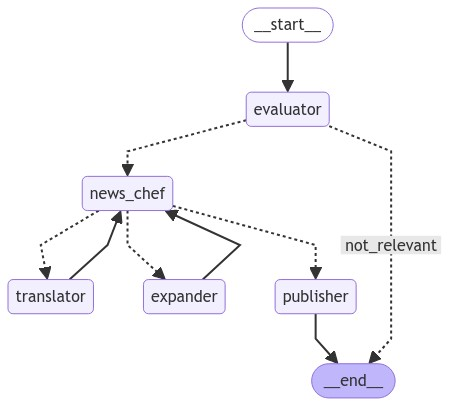

In [92]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [97]:

random_article = "Es wurde gemeldet, dass Messi von PSG zu Real Madrid wechselt."

result = app.invoke({"article_state":random_article})

print("Final result:", result)

get_transfer_news_grade: Current state:{'article_state': 'Es wurde gemeldet, dass Messi von PSG zu Real Madrid wechselt.'}
Evaluator: Reading the article but doing nothing to change it...
evaluator_router: Current state:{'article_state': 'Es wurde gemeldet, dass Messi von PSG zu Real Madrid wechselt.'}
Evaluator result: binary_score='yes'
evaluate_article: Current state:{'article_state': 'Es wurde gemeldet, dass Messi von PSG zu Real Madrid wechselt.'}
Evaluator: Reading the article but doing nothing to change it...
news_chef_router: Current state: {'article_state': 'Es wurde gemeldet, dass Messi von PSG zu Real Madrid wechselt.'}
News chef result: can_be_posted='no' meets_word_count='no' is_sensationalistic='no' is_language_english='no'
translate_article: Current state:{'article_state': 'Es wurde gemeldet, dass Messi von PSG zu Real Madrid wechselt.'}
evaluate_article: Current state:{'article_state': AIMessage(content='It has been reported that Messi is moving from PSG to Real Madrid.

In [98]:
random_article2 = "The pope will be visiting Spain today"

result = app.invoke({"article_state":random_article2})

print("Final result:", result)

get_transfer_news_grade: Current state:{'article_state': 'The pope will be visiting Spain today'}
Evaluator: Reading the article but doing nothing to change it...
evaluator_router: Current state:{'article_state': 'The pope will be visiting Spain today'}
Evaluator result: binary_score='no'
Final result: {'article_state': 'The pope will be visiting Spain today'}


### KN - chatbot

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages ## we have messages as we add them, the state of the agent keeps changing